In [1]:
!pip install --upgrade jupyter

In [2]:
!pip install scikit-learn

In [3]:
!pip install pandas

In [4]:
!pip install matplotlib

In [5]:
!pip install seaborn

In [6]:
!pip install scipy

In [7]:
!pip install nltk

In [8]:
!pip install transformers

In [9]:
!pip install tqdm

In [10]:
!pip install ipywidgets

In [11]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


### Installing the CUDA-enabled version of PyTorch

In [12]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121


In [13]:
!pip install torchtext

In [14]:
import torchtext
torchtext.disable_torchtext_deprecation_warning()

In [15]:
import pandas as pd # Data Processing, CSV file I/O
import os # This Module Provides a Portable Way of Using Operating System-Dependent Functionality
import random
import numpy as np # Linear Algebra 
%matplotlib inline
import matplotlib.pyplot as plt # Plotting library in Python
from matplotlib import style
import seaborn as sns # Statistical Data Visualization
from scipy import stats # Scientific Computing
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from math import sqrt
import string
import html
import re
import nltk
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import AdamW
from torch.cuda.amp import GradScaler, autocast  # Required for AMP
import transformers
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm

tqdm.pandas(desc="Processing")

In [16]:
# Download NLTK resources
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\musta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\musta\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Checking CUDA Availability

In [17]:
print("CUDA available:", torch.cuda.is_available())

# Setting Device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Additional Info
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

CUDA available: True
Using device: cuda
NVIDIA GeForce RTX 4060 Laptop GPU


### Loading the Dataset

In [18]:
# Getting the Current Working Directory
current_dir = os.getcwd()

print("Current Working Directory: ", current_dir)

# Going Back to One Directory and Then into the 'Dataset' Directory
train_data_path = os.path.join(current_dir, '..', 'Dataset', 'drugsComTrain_raw.csv')
test_data_path = os.path.join(current_dir, '..', 'Dataset', 'drugsComTest_raw.csv')

# Printing the Constructed Path to Verify
print("Path to the training data:", train_data_path)
print("Path to the testing data:", test_data_path)

# Loading the Datasets
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Displaying the First Few Rows of the Training Dataset
train_data.head()

Current Working Directory:  C:\Users\musta\OneDrive\Desktop\DL Project\Project Code\CS_7389H_Project-RoBERTa\Code
Path to the training data: C:\Users\musta\OneDrive\Desktop\DL Project\Project Code\CS_7389H_Project-RoBERTa\Code\..\Dataset\drugsComTrain_raw.csv
Path to the testing data: C:\Users\musta\OneDrive\Desktop\DL Project\Project Code\CS_7389H_Project-RoBERTa\Code\..\Dataset\drugsComTest_raw.csv


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [19]:
list(train_data) #List of Features

['uniqueID',
 'drugName',
 'condition',
 'review',
 'rating',
 'date',
 'usefulCount']

In [20]:
total_training_examples = train_data.values.shape[0]
total_testing_examples = test_data.values.shape[0]

print("Total Training Examples: ", total_training_examples)
print("Total Testing Examples: ", total_testing_examples)

Total Training Examples:  161297
Total Testing Examples:  53766


In [21]:
unique_condition_count_train = train_data.condition.unique().size
unique_condition_count_test = test_data.condition.unique().size

print("Number of Unique Conditions in Train Data: ", unique_condition_count_train)
print("Number of Unique Conditions in Test Data: ", unique_condition_count_test)

Number of Unique Conditions in Train Data:  885
Number of Unique Conditions in Test Data:  709


In [22]:
unique_drugName_count_train = train_data.drugName.unique().size
unique_drugName_count_test = test_data.drugName.unique().size

print("Number of Unique Drugs in Train Data: ", unique_drugName_count_train)
print("Number of Unique Drugs in Test Data: ", unique_drugName_count_test)

Number of Unique Drugs in Train Data:  3436
Number of Unique Drugs in Test Data:  2637


### Top 20 Common Conditions

In [23]:
conditions = train_data.condition.value_counts().sort_values(ascending=False)
conditions[:20]

condition
Birth Control                28788
Depression                    9069
Pain                          6145
Anxiety                       5904
Acne                          5588
Bipolar Disorde               4224
Insomnia                      3673
Weight Loss                   3609
Obesity                       3568
ADHD                          3383
Diabetes, Type 2              2554
Emergency Contraception       2463
High Blood Pressure           2321
Vaginal Yeast Infection       2274
Abnormal Uterine Bleeding     2096
Bowel Preparation             1859
ibromyalgia                   1791
Smoking Cessation             1780
Migraine                      1694
Anxiety and Stress            1663
Name: count, dtype: int64

In [24]:
style.use('ggplot')
plt.rcParams['figure.figsize'] = [8, 4]

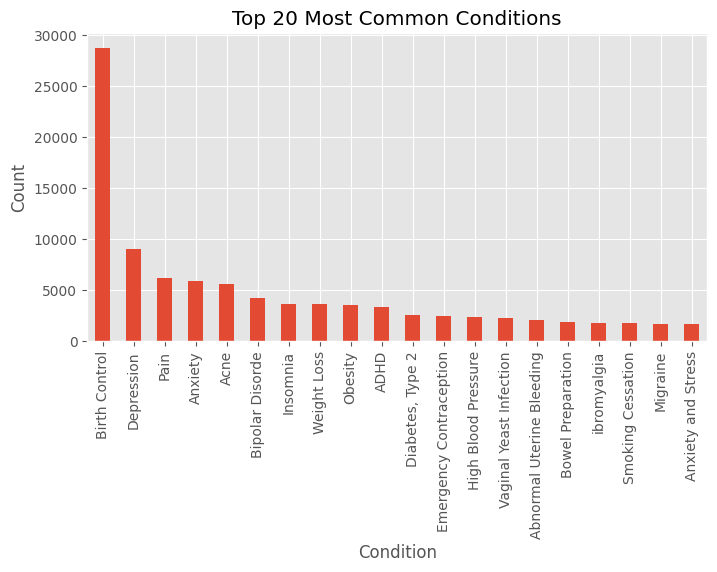

In [25]:
conditions[:20].plot(kind='bar')
plt.title('Top 20 Most Common Conditions')
plt.xlabel('Condition')
plt.ylabel('Count');

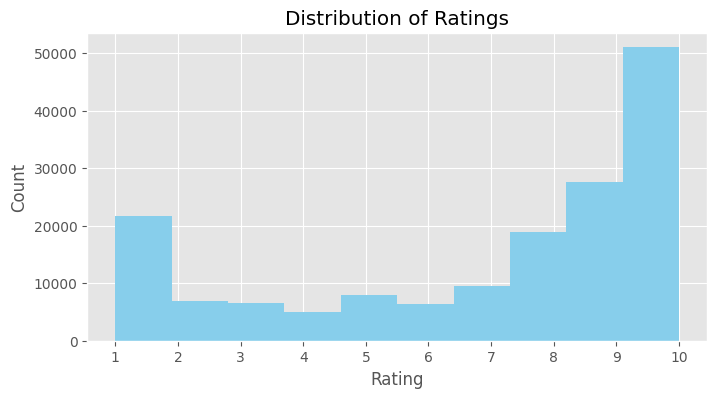

In [26]:
train_data.rating.hist(color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([i for i in range(1, 11)]);

##### Observation: People only leave reviews if the medicine is either really good or really bad. Most of the time, people leave reviews if this is good.

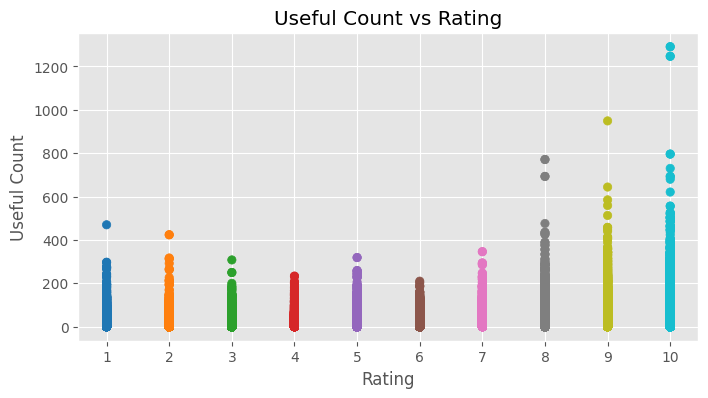

In [27]:
plt.scatter(train_data.rating, train_data.usefulCount, c=train_data.rating.values, cmap='tab10')
plt.title('Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')
plt.xticks([i for i in range(1, 11)]);

##### Observation: The more positive reviews are found by people to be more useful

In [28]:
# Creating a List (cast into an array) Containing the Average Usefulness for Given Ratings
use_ls = []

for i in range(1, 11):
    use_ls.append([i, np.sum(train_data[train_data.rating == i].usefulCount) / np.sum([train_data.rating == i])])
    
use_arr = np.asarray(use_ls)

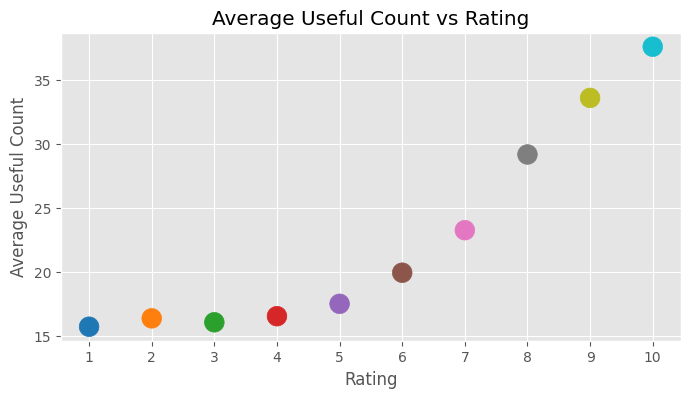

In [29]:
plt.scatter(use_arr[:, 0], use_arr[:, 1], c=use_arr[:, 0], cmap='tab10', s=200)
plt.title('Average Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Useful Count')
plt.xticks([i for i in range(1, 11)]);

##### Observation: Reviews with high ratings recieved more 'useful' tags than reviews with low ratings

### Sorting Train Dataframe from Most to Least Useful

In [30]:
useful_train = train_data.sort_values(by='usefulCount', ascending=False)
useful_train.iloc[:20]

,uniqueID,drugName,condition,review,rating,date,usefulCount
6716,96616,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291
33552,119152,Zoloft,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291
21708,131116,Levonorgestrel,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247
4249,182560,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247
146145,119151,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,5-Aug-08,949
58608,139141,Phentermine,Weight Loss,"""I have used this pill off and on for the past...",10,19-Oct-08,796
16889,52305,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,19-Oct-08,796
2039,62757,Citalopram,Depression,"""I responded after one week. The side effects ...",8,25-Mar-08,771
152838,89825,Celexa,Depression,"""I responded after one week. The side effects ...",8,25-Mar-08,771
5218,107655,Implanon,Birth Control,"""I was very nervous about trying Implanon afte...",10,19-Jul-10,730


### Printing top 3 Most Useful Reviews

In [31]:
for i in useful_train.review.iloc[:3]:
    print(i, '\n')

"I remember reading people&#039;s opinions, online, of the drug before I took it and it scared me away from it. Then I finally decided to give it a try and it has been the best choice I have made. I have been on it for over 4 months and I feel great. I&#039;m on 100mg and I don&#039;t have any side effects. When I first started I did notice that my hands would tremble but then it subsided. So honestly, don&#039;t listen to all the negativity because what doesn&#039;t work for some works amazing for others. So go based on youself and not everyone else. It may be a blessing in diguise. The pill is not meant to make you be all happy go lucky and see &quot;butterflies and roses&quot;, its meant to help put the chemicals in your mind in balance so you can just be who you are and not overly depressed. I still get sad some times, but that is normal, that is life, and it&#039;s up to people to take control to make a change. I did so by getting on this pill." 

"I remember reading people&#039;s

### Printing top 3 Least Useful Reviews

In [32]:
for i in useful_train.review.iloc[-3:]:
    print(i, '\n')

"I received Implanon in May of 2008. I am due to have it removed in 6 months however, for the past year I have experienced decrease in sex drive, weight gain of 30lbs and also mood swings. My periods have been very scheduled and fairly regular which was great until 4-5 months ago when I missed a period then was on time the following 2 months. Last month I started a week early and it was unusually light, this month I started 2 1/2 weeks early and it has been off and on spotting for the past 5 days. I did call the helpline when I missed my period. They did not seem to concerned and I have not been able to find ANYwhere the birth rates on this specific birth control! I loved it until a year ago so the first half of my experience was great the last half no." 

"The only warning my gyno gave me was that I would be spotting for about 15 days after having the IUD inserted, which was a damn lie.  I spotted for a whole four weeks after the procedure.  My uterus chilled for two weeks before I st

##### Observation: Reviewers find higher ratings/better reviews to be more useful than lower ratings/worse reviews

### Quantifying the sentiment of these reviews

In [33]:
sid = SentimentIntensityAnalyzer()

In [34]:
# Creating list (cast to array) of Compound Polarity Sentiment Scores for Reviews
sentiments = []

for i in train_data.review:
    sentiments.append(sid.polarity_scores(i).get('compound'))
    
sentiments = np.asarray(sentiments)

In [35]:
sentiments

array([-0.296 ,  0.8603,  0.7962, ..., -0.743 ,  0.6197,  0.6124])

In [36]:
useful_train['sentiment'] = pd.Series(data=sentiments)

In [37]:
useful_train = useful_train.reset_index(drop=True)
useful_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment
0,96616,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291,0.9772
1,119152,Zoloft,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291,0.9772
2,131116,Levonorgestrel,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247,0.7739
3,182560,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247,0.7739
4,119151,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,5-Aug-08,949,-0.6815


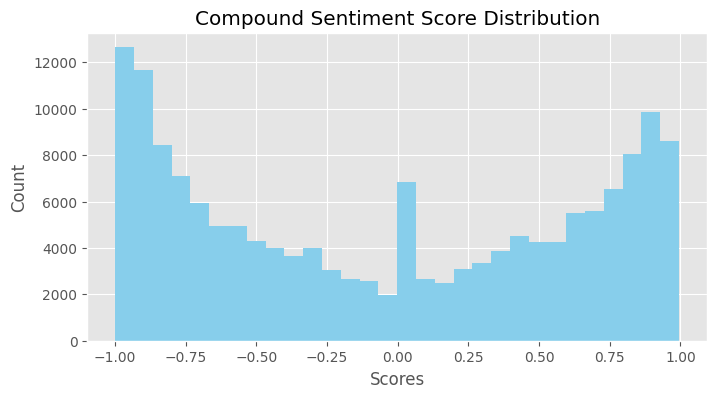

In [38]:
useful_train.sentiment.hist(color='skyblue', bins=30)
plt.title('Compound Sentiment Score Distribution')
plt.xlabel('Scores')
plt.ylabel('Count');

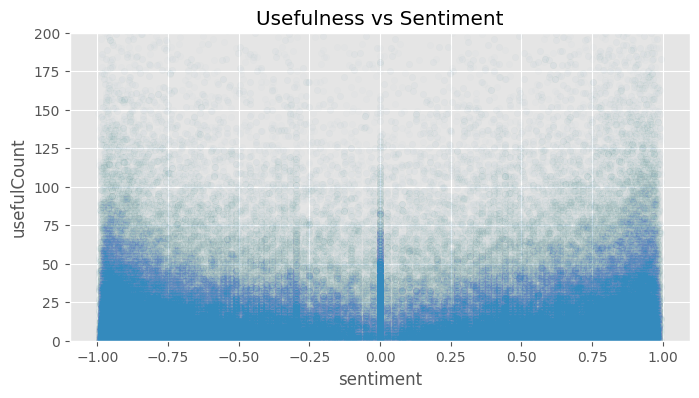

In [39]:
useful_train.plot(x='sentiment', y='usefulCount', kind='scatter', alpha=0.01)
plt.title('Usefulness vs Sentiment')
plt.ylim(0, 200);

In [40]:
temp_ls = []

for i in range(1, 11):
    temp_ls.append(np.sum(useful_train[useful_train.rating == i].sentiment) / np.sum(useful_train.rating == i))

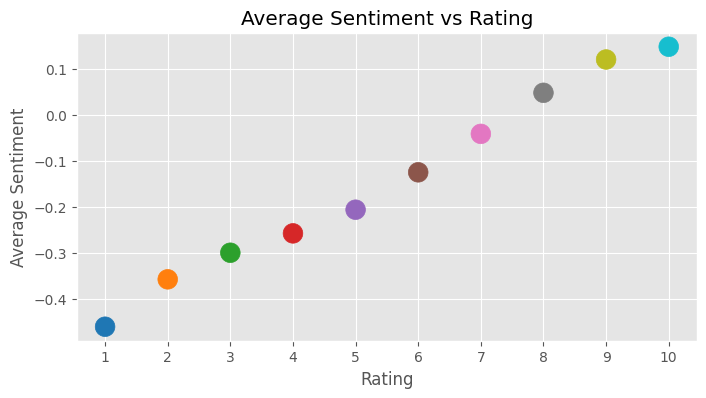

In [41]:
plt.scatter(x=range(1, 11), y=temp_ls, c=range(1, 11), cmap='tab10', s=200)
plt.title('Average Sentiment vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment')
plt.xticks([i for i in range(1, 11)]);

### 30 most Common Drugs

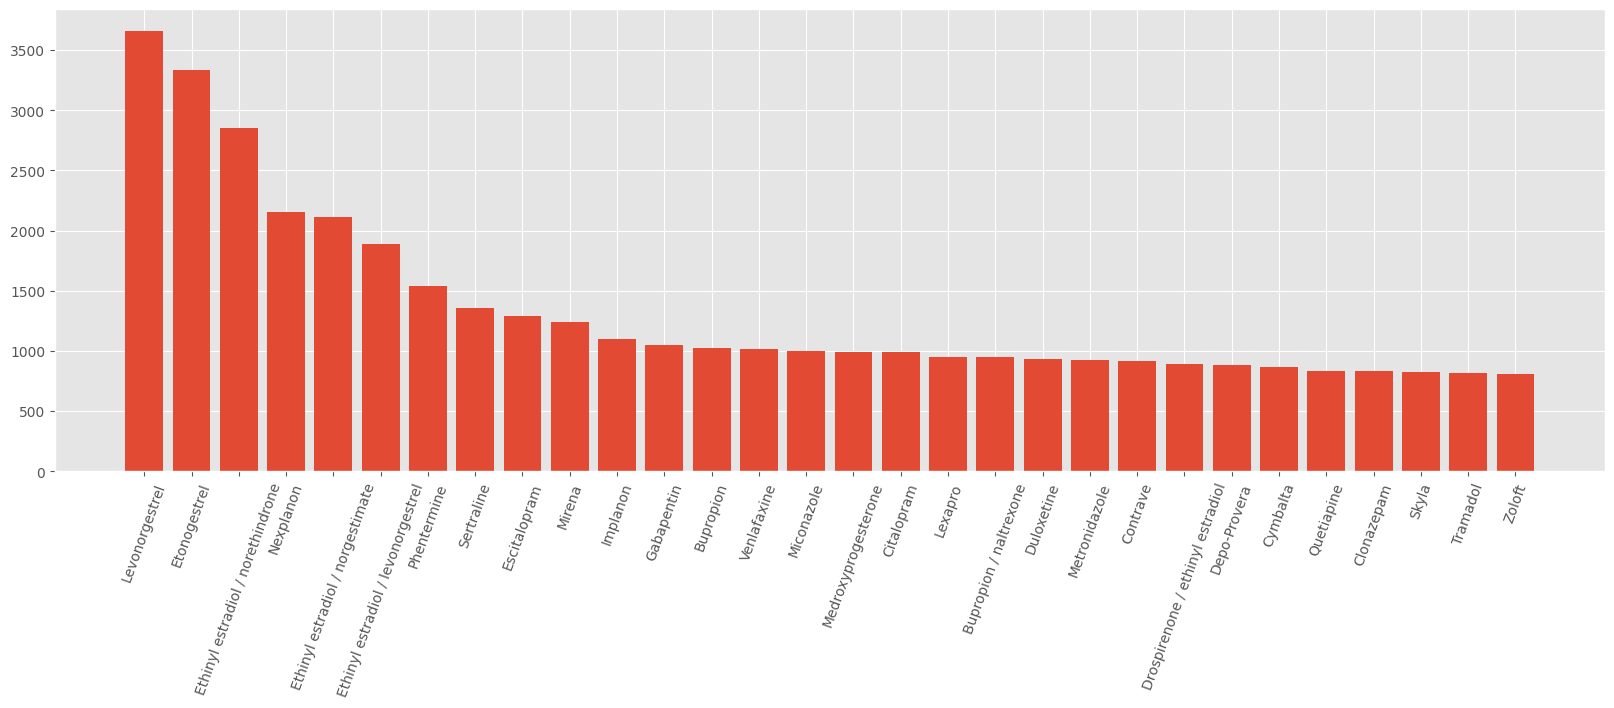

In [42]:
drugcounts = train_data['drugName'].value_counts()
drugcounts_filtered = drugcounts[drugcounts >= 10]

plt.figure(figsize=(20,6))
plt.bar(drugcounts[:30].index, drugcounts[:30])
plt.xticks(rotation=70)
plt.show()

### Finding the Best-Reviewed Drugs Overall

In [43]:
# Creating a List of All Drugs and Their Average Ratings, Casting to dataframe
rate_ls = []

for i in train_data.drugName.unique():
    
    # Only consider drugs that have at least 10 ratings
    if np.sum(train_data.drugName == i) >= 10:
        rate_ls.append((i, np.sum(train_data[train_data.drugName == i].rating) / np.sum(train_data.drugName == i)))
    
avg_rate = pd.DataFrame(rate_ls)

In [44]:
# Creating a Dataframe from the List
avg_rate = pd.DataFrame(rate_ls)

# Setting the Column Names for the dataframe
avg_rate.columns = ['Drug Name', 'Rating']

# Sorting the Dataframe by the 'Rating' Column
avg_rate = avg_rate.sort_values(by='Rating', ascending=False).reset_index(drop=True)

# Displaying the Top 10 Rows
avg_rate.head(10)

,Drug Name,Rating
0,Zutripro,10.000000
1,Chlorpheniramine / hydrocodone / pseudoephedrine,10.000000
2,Silver sulfadiazine,9.972222
3,Drixoral Cold and Allergy,9.948718
4,Dexbrompheniramine / pseudoephedrine,9.947368
5,Emend,9.900000
6,Aprepitant,9.900000
7,Tegaserod,9.812500
8,Zelnorm,9.687500
9,Cyanocobalamin,9.666667


### Finding the Worst-Reviewed Drugs Overall

In [45]:
# Displaying the Last 10 Rows
avg_rate.tail(10)

,Drug Name,Rating
1371,Prevnar 13,3.363636
1372,Fosamax,3.166667
1373,Blisovi 24 Fe,3.088889
1374,Opdivo,3.083333
1375,Miconazole,3.033000
1376,Monistat 7,3.032258
1377,Alendronate,2.954545
1378,Yuvafem,2.318182
1379,Monistat 1-Day or Night Combination Pack,1.416667
1380,ProAir RespiClick,1.193548


### Finding the Highest Rated Drugs For Birth Control

In [46]:
# Making a Dictionary of Conditions; Each Value will be a dataframe of All of the Drugs Used to Treat the Given Condition
drug_dict = {}

# Iterating Over Conditions
for i in train_data.condition.unique():
    
    temp_ls = []
    
    # Iterating Over Drugs Within a Given Condition
    for j in train_data[train_data.condition == i].drugName.unique():
        
        # If There are at least 10 Reviews for a Drug, Saving its Name and Average Rating in the Temporary List
        if np.sum(train_data.drugName == j) >= 10:
            temp_ls.append((j, np.sum(train_data[train_data.drugName == j].rating) / np.sum(train_data.drugName == j)))
        
    # Saving Temporary List as a dataframe as a value in Help Dictionary, Sorted Best to Worst Drugs
    drug_dict[i] = pd.DataFrame(data=temp_ls, columns=['drug', 'average_rating']).sort_values(by='average_rating', ascending=False).reset_index(drop=True)

In [47]:
drug_dict['Birth Control'].iloc[:10]

,drug,average_rating
0,Plan B,8.674917
1,Lybrel,7.600000
2,Ortho Evra,7.470320
3,Kyleena,7.463576
4,Levonorgestrel,7.391031
5,Ortho-Cept,7.250000
6,Skyla,7.246359
7,Copper,7.235197
8,Beyaz,7.042553
9,Dienogest / estradiol,6.875000


### Finding the Lowest Rated Drugs For Birth Control

In [48]:
drug_dict['Birth Control'].iloc[:-10]

,drug,average_rating
0,Plan B,8.674917
1,Lybrel,7.600000
2,Ortho Evra,7.470320
3,Kyleena,7.463576
4,Levonorgestrel,7.391031
...,...,...
92,Falmina,4.964286
93,Junel Fe 1.5 / 30,4.961538
94,Vienva,4.833333
95,Errin,4.821429


## Experimenting with RoBERTa

In [49]:
#For Reproducibility
SEED = 508
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(SEED)

In [50]:
# Constants
SEED = 508
MAX_LEN = 128  # Maximum Length of Input Sequences
BATCH_SIZE = 16
EPOCHS = 10

### Text Preprocessing

In [51]:
# Defining the Tokenizer from the Pre-trained RoBERTa Model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [52]:
# Preprocessing Function
def preprocess_text(text):
    text = html.unescape(text)
    text = re.sub(r'https?:\/\/\S+', ' ', text)
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Data Augmentation Functions
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)


def synonym_replacement(sentence, n=1):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) > 0:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    sentence = ' '.join(new_words)
    return sentence


def augment_text(df, class_column='rating', n_augmentations=4):
    augmented_texts = []
    classes_to_augment = [cls for cls in df[class_column].unique() if 0 < cls < 9]
    for label in classes_to_augment:
        minority_class_reviews = df[df[class_column] == label]['review']
        for i, review in enumerate(minority_class_reviews):
            for _ in range(n_augmentations):
                augmented_review = synonym_replacement(review)
                if i < 2:
                    print(f"Original ({label}): {review}")
                    print(f"Augmented ({label}): {augmented_review}")
                augmented_texts.append({'review': augmented_review, 'rating': label})
    return pd.DataFrame(augmented_texts)


def custom_undersample(data, class_to_reduce, reduction_factor):
    # Reduce the samples from specific classes
    reduced_data = data[~data['rating'].isin(class_to_reduce)]
    data_to_reduce = data[data['rating'].isin(class_to_reduce)]
    reduced_samples = data_to_reduce.groupby('rating').sample(
        frac=reduction_factor, random_state=SEED).reset_index(drop=True)
    return pd.concat([reduced_data, reduced_samples]).sample(frac=1, random_state=SEED).reset_index(drop=True)

In [53]:
class DrugReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        target = int(self.targets[idx])
        encoding = self.tokenizer.encode_plus(
            review, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [54]:
def create_data_loader(df, tokenizer, max_len, batch_size, shuffle=True):
    ds = DrugReviewDataset(df['review'].to_numpy(), df['rating'].to_numpy(), tokenizer, max_len)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

In [55]:
def print_distribution(data, label):
    distribution = data['rating'].value_counts().sort_index()
    print(f"\nDistribution in {label}:")
    print(distribution)
    print(f"Total samples in {label}: {len(data)}\n")

In [56]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction=self.reduction, weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [57]:
# Preprocessing Data
train_data['review'] = train_data['review'].progress_apply(preprocess_text)
train_data['rating'] = train_data['rating'].astype(int) - 1
print_distribution(train_data, "Initial Training Set")

Processing: 100%|██████████| 161297/161297 [00:03<00:00, 46820.70it/s]


Distribution in Initial Training Set:
rating
0    21619
1     6931
2     6513
3     5012
4     8013
5     6343
6     9456
7    18890
8    27531
9    50989
Name: count, dtype: int64
Total samples in Initial Training Set: 161297



In [58]:
# Data Augmentation
n_augmentations_per_review = 4
augmented_train_data = augment_text(train_data, 'rating', n_augmentations_per_review)
train_data_combined = pd.concat([train_data, augmented_train_data]).sample(frac=1, random_state=SEED).reset_index(drop=True)
print_distribution(train_data_combined, "Post-Augmentation Training Set")

Original (8): It has no side effect I take it in combination of Bystolic 5 Mg and Fish Oil
Augmented (8): It has no face effect I take it in combination of Bystolic 5 Mg and Fish Oil
Original (8): It has no side effect I take it in combination of Bystolic 5 Mg and Fish Oil
Augmented (8): It has no side effect I choose it in combination of Bystolic 5 Mg and Fish Oil
Original (8): It has no side effect I take it in combination of Bystolic 5 Mg and Fish Oil
Augmented (8): It has atomic number 102 side effect I take it in combination of Bystolic 5 Mg and Fish Oil
Original (8): It has no side effect I take it in combination of Bystolic 5 Mg and Fish Oil
Augmented (8): It has no side effect i take it in combination of Bystolic 5 Mg and Fish Oil
Original (8): Suboxone has completely turned my life around I feel healthier I m excelling at my job and I always have money in my pocket and my savings account I had none of those before Suboxone and spent years abusing oxycontin My paycheck was alre

In [59]:
# Custom Undersampling
train_data_reduced = custom_undersample(train_data_combined, class_to_reduce=[7, 8], reduction_factor=0.5)
train_data_final, val_data_final = train_test_split(train_data_reduced, test_size=0.2, random_state=SEED)
print_distribution(train_data_final, "Final Training Set")
print_distribution(val_data_final, "Validation Set")


Distribution in Final Training Set:
rating
0    17208
1    27839
2    26089
3    20111
4    32137
5    25311
6    37823
7    37819
8    54834
9    40829
Name: count, dtype: int64
Total samples in Final Training Set: 320000


Distribution in Validation Set:
rating
0     4411
1     6816
2     6476
3     4949
4     7928
5     6404
6     9457
7     9406
8    13994
9    10160
Name: count, dtype: int64
Total samples in Validation Set: 80001



In [60]:
test_data['review'] = test_data['review'].progress_apply(preprocess_text)
test_data['rating'] = test_data['rating'].astype(int) - 1
print_distribution(test_data, "Test Set")

Processing: 100%|██████████| 53766/53766 [00:01<00:00, 47131.10it/s]


Distribution in Test Set:
rating
0     7299
1     2334
2     2205
3     1659
4     2710
5     2119
6     3091
7     6156
8     9177
9    17016
Name: count, dtype: int64
Total samples in Test Set: 53766



In [61]:
# Creating DataLoaders
train_data_loader = create_data_loader(train_data_final, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=True)
val_data_loader = create_data_loader(val_data_final, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=False)
test_data_loader = create_data_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=False)

In [62]:
# Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_data_final['rating']), y=train_data_final['rating'])
class_weights_tensor = torch.tensor(list(class_weights), dtype=torch.float).to(device)

### Initializing RoBERTa Model

In [63]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=10)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

### Setting up Optimizer, Scheduler, and Loss Function

In [64]:
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=total_steps // 10, num_training_steps=total_steps)
criterion = FocalLoss(weight=torch.tensor(compute_class_weight('balanced', classes=np.unique(train_data_final['rating']), y=train_data_final['rating']), dtype=torch.float).to(device))
scaler = GradScaler()

In [65]:
def train_epoch(model, data_loader, optimizer, device, scheduler, criterion, scaler):
    model.train()
    total_loss = 0
    correct_predictions = 0
    processed_data = 0

    progress_bar = tqdm(data_loader, desc='Training', leave=False)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == targets)
        processed_data += targets.size(0)
        total_loss += loss.item()

        accuracy = correct_predictions.double() / processed_data
        progress_bar.set_postfix({'train_loss': loss.item(), 'accuracy': accuracy.item()})
    
    progress_bar.close()
    return total_loss / len(data_loader), accuracy.item()

In [66]:
def eval_model(model, data_loader, device, criterion):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    processed_data = 0

    progress_bar = tqdm(data_loader, desc='Evaluating', leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)
            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = criterion(logits, targets)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(preds == targets)
            processed_data += targets.size(0)

            accuracy = correct_predictions.double() / processed_data
            progress_bar.set_postfix({'val_loss': loss.item(), 'accuracy': accuracy.item()})

    progress_bar.close()
    return total_loss / len(data_loader), accuracy.item()

In [67]:
def test_model(model, test_data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    print("Testing started.") 

    progress_bar = tqdm(test_data_loader, desc="Testing", leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['targets'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Testing completed.")  
    return all_labels, all_preds

In [68]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

### Training and Validating

In [69]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    train_loss, train_accuracy = train_epoch(model, train_data_loader, optimizer, device, scheduler, criterion, scaler)
    val_loss, val_accuracy = eval_model(model, val_data_loader, device, criterion)
    print(f"Epoch {epoch}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)

Epoch 0, Train Loss: 1.1881757234886288, Train Accuracy: 0.320134375, Val Loss: 0.8969060683507868, Val Accuracy: 0.39273259084261447


Epoch 1, Train Loss: 0.7342086394341663, Train Accuracy: 0.47480625000000004, Val Loss: 0.49904444195416553, Val Accuracy: 0.581292733840827


Epoch 2, Train Loss: 0.3105329556152923, Train Accuracy: 0.653325, Val Loss: 0.1727466806148303, Val Accuracy: 0.7337283283958951


Epoch 3, Train Loss: 0.1279586391356068, Train Accuracy: 0.755946875, Val Loss: 0.08517511569940968, Val Accuracy: 0.8030149623129711


Epoch 4, Train Loss: 0.06366866102220466, Train Accuracy: 0.814671875, Val Loss: 0.06288520280177362, Val Accuracy: 0.8236647041911976


Epoch 5, Train Loss: 0.03393349071578032, Train Accuracy: 0.856365625, Val Loss: 0.04418492893292571, Val Accuracy: 0.8628142148223147


Epoch 8, Train Loss: 0.005362656669862843, Train Accuracy: 0.93419375, Val Loss: 0.02959140971017397, Val Accuracy: 0.9141010737365782


Epoch 9, Train Loss: 0.0029807562597786524, Train Accuracy: 0.9493812500000001, Val Loss: 0.029057197535889468, Val Accuracy: 0.9185385182685216


### Plotting the Losses

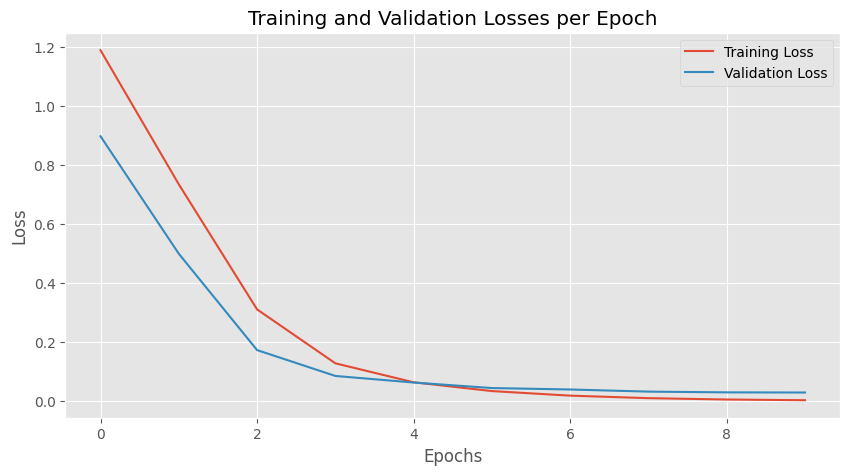

In [70]:
plot_losses(train_losses, val_losses)

### Testing the Model

In [71]:
test_labels, test_predictions = test_model(model, test_data_loader, device)
if test_labels is not None and test_predictions is not None:
    test_accuracy = accuracy_score(test_labels, test_predictions)
    print(f"Test Accuracy: {test_accuracy}")
    print("Classification Report:\n", classification_report(test_labels, test_predictions))

Testing started.


Testing completed.
Test Accuracy: 0.69240784138675
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.87      0.82      7299
           1       0.73      0.67      0.70      2334
           2       0.73      0.68      0.71      2205
           3       0.81      0.65      0.72      1659
           4       0.68      0.68      0.68      2710
           5       0.73      0.64      0.68      2119
           6       0.69      0.65      0.67      3091
           7       0.62      0.58      0.60      6156
           8       0.59      0.42      0.49      9177
           9       0.70      0.83      0.76     17016

    accuracy                           0.69     53766
   macro avg       0.71      0.67      0.68     53766
weighted avg       0.69      0.69      0.68     53766



### Computing and Printing the Confusion Matrix

In [72]:
cm = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 6317   354   200    53   136    32    21    45    28   113]
 [  485  1553    81    29    79    19    13    33     7    35]
 [  344    81  1496    41    96    31    21    26    18    51]
 [  165    56    69  1083   109    30    30    56    13    48]
 [  230    31    74    43  1844   100    95   108    65   120]
 [  121    25    39    33   105  1353    94   153    64   132]
 [   80     4    31    23   118    95  1997   300   149   294]
 [   97    10    18    19   103    83   285  3550   665  1326]
 [   83     7    10     5    62    53   170   839  3877  4071]
 [  165    14    20    10    59    62   163   646  1719 14158]]


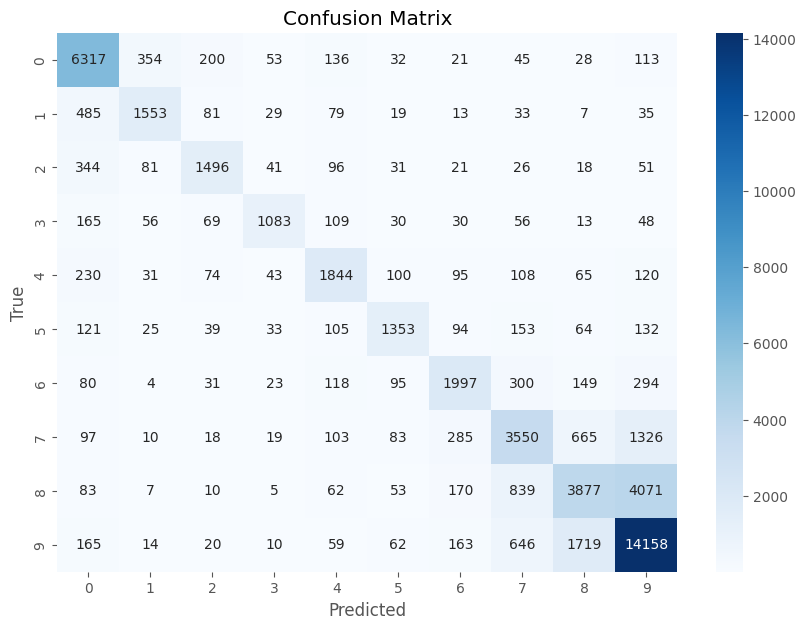

In [73]:
# Plotting the Confusion Matrix Using Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()